In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
import pandas as pd
import geopandas as gp
import numpy as np
from statistics import mean, median

**Load data**

In [2]:
# Retrieve demographic data from Census API

#code chunk by Melisande Teng - VRDI 2019
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN",
    "NH_ASIAN",
    "NH_NHPI",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

import requests

def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes


def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [3]:
va_demo = block_data_for_state('51')

In [4]:
va_demo = va_demo.rename(columns={"geoid": "GEOID10"})

In [5]:
# blocks = pd.read_csv("./raw-from-source/demographic_data/nhgis_ds172_2010_block.csv") #NHGIS data

block_shp = gp.read_file("./raw-from-source/VA_blk-level_shapefile/tl_2017_51_tabblock10.shp")
precincts = gp.read_file("./raw-from-source/PGP-election-precincts/VA_Precincts_Elections.shp")

**set shapefile projections**

In [6]:
precincts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
precincts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
proj = precincts.crs

In [9]:
precincts = precincts.to_crs(proj)
block_shp = block_shp.to_crs(proj)

**Join block-level deomographic data with block-level shapefile**

In [10]:
#Join
blk_joined = pd.merge(block_shp, va_demo, on='GEOID10', how='left', indicator=True)

In [11]:
# Check total population - join is good!
blk_joined.TOTPOP.sum()

8001024

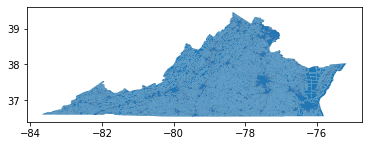

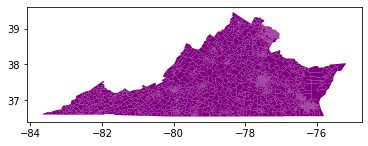

In [12]:
blk_joined.plot()
precincts.plot(color='purple')

### Prorate Demographic and Voting Population Data from the Block level to Precincts

In [13]:
proj = blk_joined.crs

In [14]:
blk_joined["geometry"] = blk_joined.buffer(0)
precincts["geometry"] = precincts.buffer(0)

In [19]:
variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

blk_joined = blk_joined.to_crs(proj)

pieces = maup.assign(blk_joined, precincts)

In [22]:
variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP']

In [23]:
precincts[variables] = blk_joined[variables].groupby(pieces).sum()

In [25]:
precincts.TOTPOP.sum()

8001024

**Assign congressional districts to precincts**

In [26]:
cd = gp.read_file('./raw-from-source/congressional_districts/Mod_16_shpfile.shp')

In [27]:
cd = cd.to_crs(proj)

In [28]:
assignments = maup.assign(precincts, cd)

In [29]:
# There is no '0' district, need to add 1 to IDs
assignments = assignments + 1.0

In [30]:
precincts["CD_DIST"] = assignments

**Assign house districts to blocks**

**_2011_**

In [31]:
state_house11 = gp.read_file('./raw-from-source/house_districts2011/HB5005_passed_042811_houseplan.shp')

In [ ]:
state_house11["geometry"] = state_house11.buffer(0)

In [32]:
assignments = maup.assign(precincts, state_house11)

In [33]:
# There is no '0' district, need to add 1 to IDs
assignments += 1

precincts["HD_DIST11"] = assignments

**_2019_**

In [34]:
state_house19 = gp.read_file('./raw-from-source/house_districts2019/final_remedial_plan.shp')

In [35]:
state_house19["geometry"] = state_house19.buffer(0)

In [36]:
assignments = maup.assign(precincts, state_house19)

In [37]:
# There is no '0' district, need to add 1 to IDs
assignments += 1

precincts["HD_DIST19"] = assignments

**Matched districts correspond to those included in precinct data**

In [38]:
precincts[['CD_DIST', 'district']]

,CD_DIST,district
0,2.0,Congressional District 2
1,2.0,Congressional District 2
2,2.0,Congressional District 2
3,2.0,Congressional District 2
4,3.0,Congressional District 3
...,...,...
2434,2.0,Congressional District 2
2435,2.0,Congressional District 2
2436,2.0,Congressional District 2
2437,2.0,Congressional District 2


In [58]:
## Save shapefile
# precincts.to_file("VA_MGGG_replication-census.shp")

### Load MGGG VA shapefile to compare results

In [40]:
final = gpd.read_file('./MGGG-final/VA_precincts.shp')

In [41]:
precincts = precincts.rename(columns={"Precinct": "precinct"})

In [42]:
validate = pd.merge(precincts, final, on=['loc_prec'], how='left')

**Check population**

In [45]:
validate['pop_diff'] = validate.TOTPOP_x - validate.TOTPOP_y

**99% of precincts have a popultion deviation of 10 or less people**

In [46]:
validate[validate.pop_diff.abs()<10].shape[0] / validate.shape[0]

0.993439934399344

**99% of precincts have a black popultion deviation of 10 or less people**

In [47]:
validate['bpop_diff'] = validate.NH_BLACK_x - validate.NH_BLACK_y

In [48]:
validate[validate.bpop_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check voting age population**

In [49]:
validate['bvap_diff'] = validate.BVAP_x - validate.BVAP_y

**99% of precincts have a black voting age popultion deviation of 10 or less people**

In [50]:
validate[validate.bvap_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check state house districts**

In [51]:
validate.HD_DIST11 = validate.HD_DIST11.astype(int)
validate.HDIST_11 = validate.HDIST_11.astype(int)
validate.HDIST_REM = validate.HDIST_REM.astype(int)

**All state House districts match MGGG's assigned state House districts**

**_2011_**

In [52]:
#number of districts that don't match MGGG's
validate[['HD_DIST11', 'HDIST_11']].assign(NE=validate.HDIST_11 != validate.HD_DIST11)['NE'].sum()

0

In [53]:
validate[['HD_DIST11', 'HDIST_11']].head()

,HD_DIST11,HDIST_11
0,79,79
1,79,79
2,100,100
3,100,100
4,89,89


**_2019_**

In [54]:
#number of districts that don't match MGGG's
validate[['HDIST_REM', 'HD_DIST19']].assign(NE=validate.HD_DIST19 != validate.HDIST_REM)['NE'].sum()

0

In [55]:
validate[['HDIST_REM', 'HD_DIST19']].head()

,HDIST_REM,HD_DIST19
0,79,79
1,79,79
2,100,100
3,100,100
4,89,89


**Check votes of 2018 Democratic US House candidate by congressional district**

In [56]:
precincts.groupby('CD_DIST')['G18DHOR'].sum()

CD_DIST
1.0     149331
2.0     139352
3.0     197954
4.0     188566
5.0     144769
6.0     113044
7.0     175172
8.0     248981
9.0      85903
10.0    200994
11.0    221464
Name: G18DHOR, dtype: int64

**Check votes of 2018 Democratic US House candidate by congressional district**

In [57]:
precincts.groupby('HD_DIST11')['G17DHOD'].sum().head(10)

HD_DIST11
1      4589
2     13552
3      3681
4       130
5         9
6         3
7      8948
8     10070
9      6177
10    15179
Name: G17DHOD, dtype: int64